# Backtesting
**Camilo Garcia Trillos 2020**

## In this notebook

In this notebook, we continue our work on estimating Value at Risk (at level 99%) and Expected Shortfall (at level 95%) for one stock (simplest case), by focusing in backtetsing these risk measures.

Since we are continuing the work we initiated the previous week, we will run from this notebook notebook with '11. Risk measure estimation', and build on top of the results. It is recommended that you open also this file in parallel to this one, in case you have any doubts in the notation.

Now, to import that file and its results in Jupyter notebooks, we can use the magic command 'run' (To do so in pure Python we can import one file into another using import).

(3756,) (3756,)


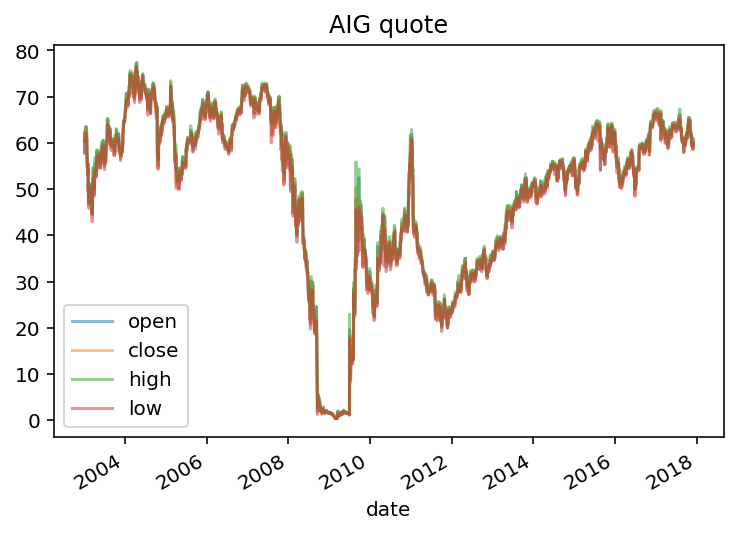

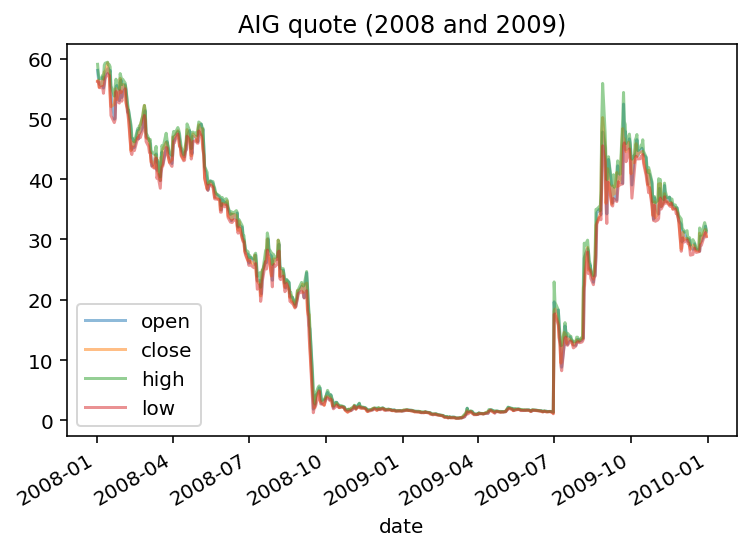

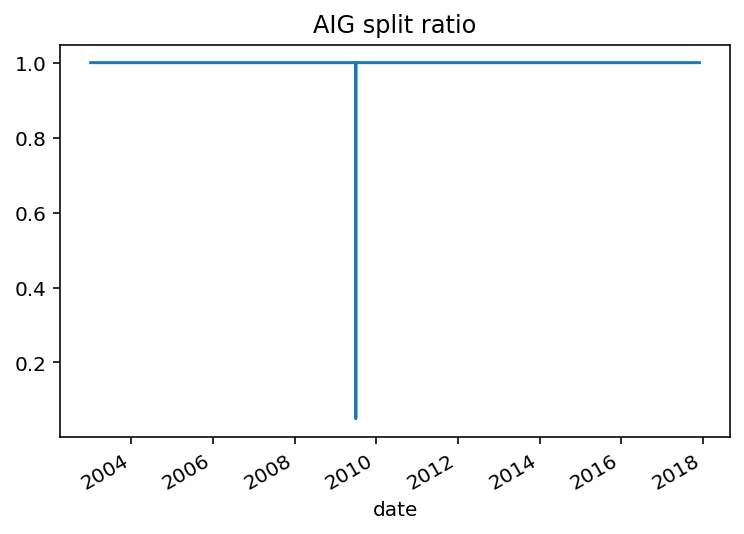

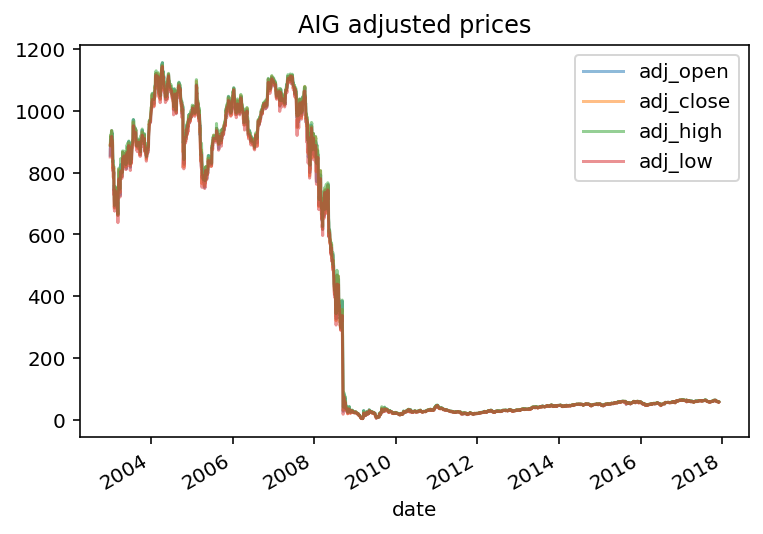

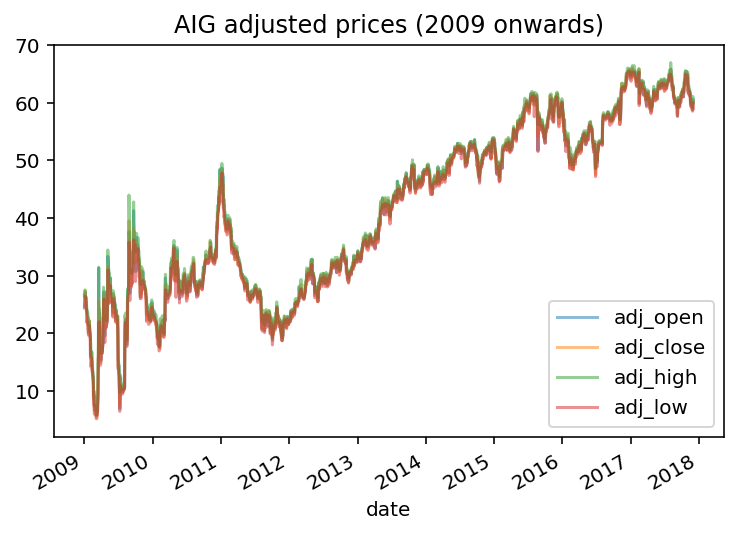

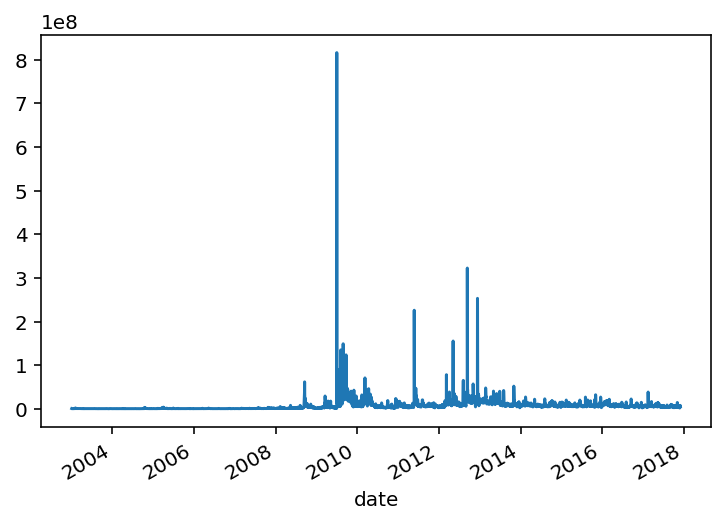

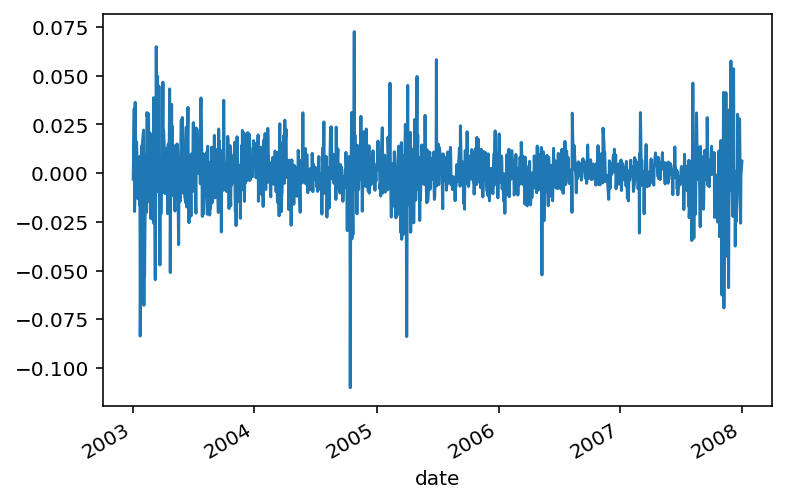

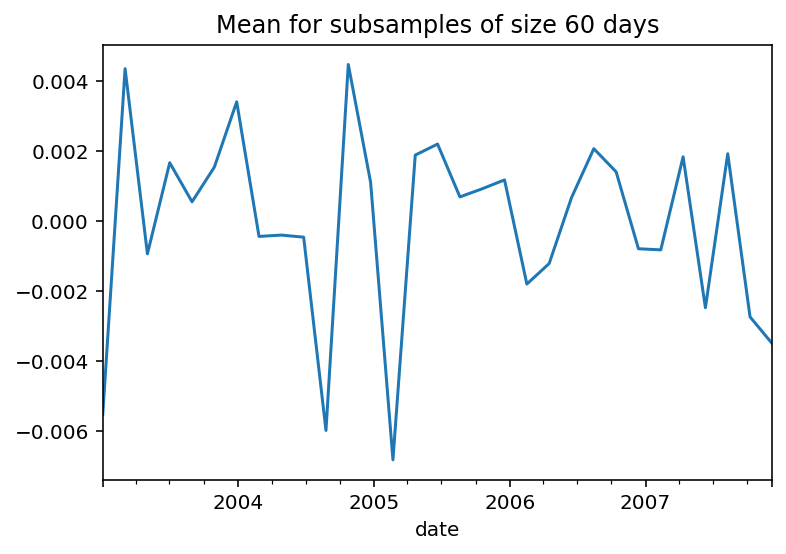

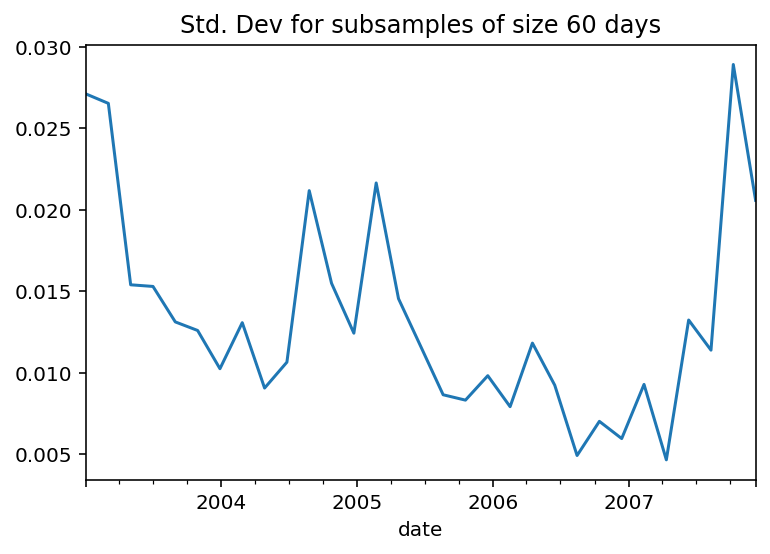

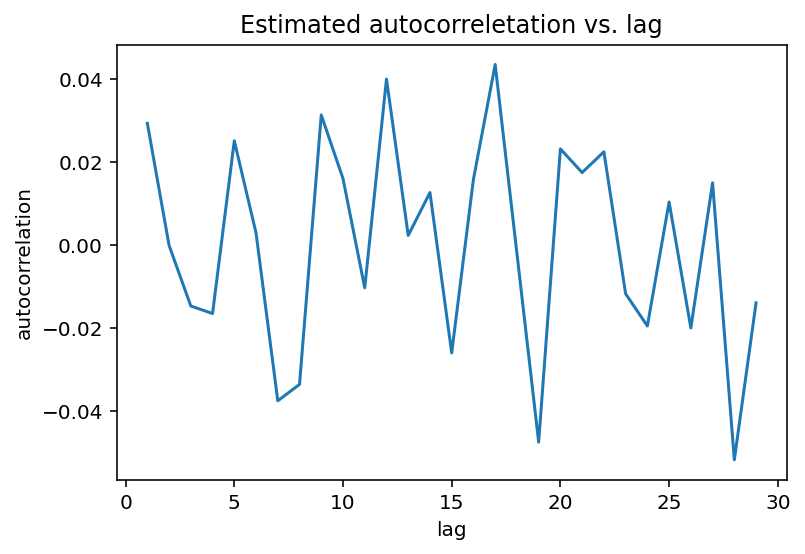

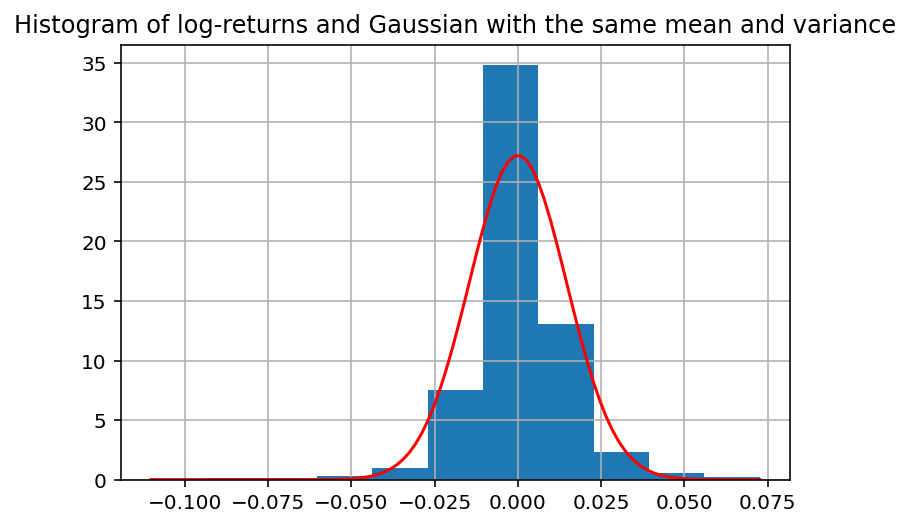

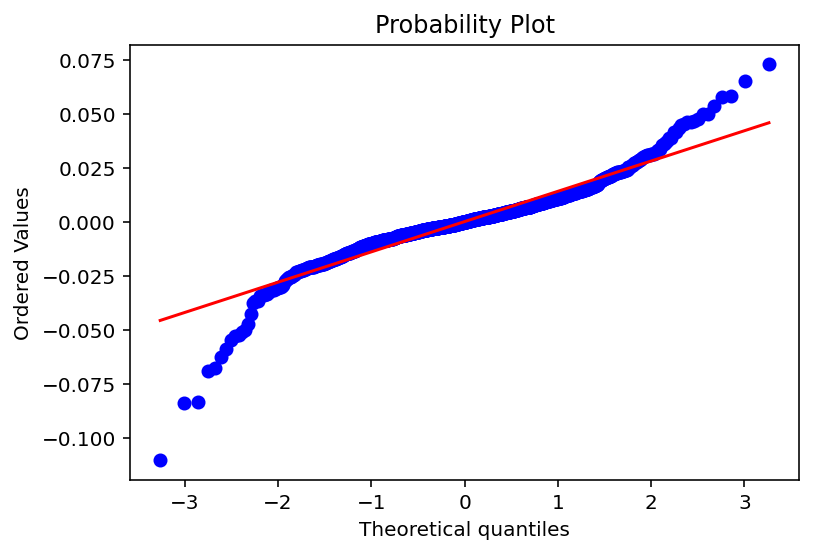

CLOSED FORM: 
Each unit of stock of AIG with closing date  2007-12-31 00:00:00  and closing (adjusted) value of  899.2590883868303  has for one day a VaR at level  0.99  of  30.624608057569294  and a one day ES at level  0.975  of  30.775447760353096 .


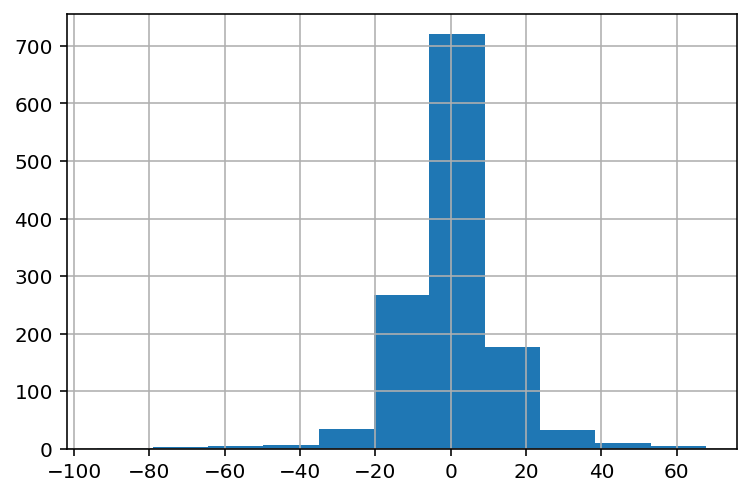

11 30
Historical Simulation: 
Each unit of stock of AIG with closing date  2007-12-31 00:00:00  and closing (adjusted) value of  899.2590883868303  has for one day a VaR at level  0.99  of  44.16004451899178  and a one day ES at level  0.975  of  40.86661378600221 .
Increase (in %) w.r.t. close form: VaR: 44.197909197655896 ES: 32.78966435916231


In [1]:
%run "~/Notebooks/Week 9/11. Risk measure estimation.ipynb"

## Rolling calculation and backtesting

Having recovered the calculations of that notebook, we can start the backtesting task by constructing a database with only the information that we need.

In [2]:
sub_aig_data = pd.DataFrame(aig_data['adj_close'])
sub_aig_data['P_and_L'] = sub_aig_data['adj_close'].diff()
sub_aig_data['log_price'] = np.log(sub_aig_data['adj_close'])
sub_aig_data['log_returns'] = sub_aig_data['log_price'].diff()
sub_aig_data.drop(sub_aig_data.index[0], inplace=True)
sub_aig_data.head()

adj_close    P_and_L  log_price  log_returns
date                                                     
2003-01-03  885.350097  -2.650749   6.785983    -0.002990
2003-01-06  915.097389  29.747292   6.819030     0.033047
2003-01-07  897.278467 -17.818922   6.799366    -0.019664
2003-01-08  886.086416 -11.192050   6.786814    -0.012552
2003-01-09  918.926249  32.839832   6.823206     0.036391

Now, we are going to build a function that, receives the above database, and returns the database after adding columns for:
- The closed form approximated VaR at level alpha_VaR
- The historical simulated VaR at level alpha_VaR
- The closed form approximated ES at level alpha_ES
- The historical simulated ES at level alpha_ES

The function starts to fill the rows at a given date 'first_calc_date' and, unless specified the number of days in rolling history to use, uses the whole history up to that point for the calculation.

**Note:** The function is not designed for optimal performance.

In [3]:
def risk_approx( data, first_calc_date, alpha_var, alpha_es, window_size =None):
    
    calc_dates_vect = data.index[data.index>= first_calc_date]
    
    #Creates the new columns and fills with NAN (not a number). This is the Panda's identifier for missing data.
    
    data['VaR_CF'] = np.empty(data['adj_close'].count()) * np.nan
    data['VaR_HS'] = np.empty(data['adj_close'].count()) * np.nan
    data['ES_CF'] = np.empty(data['adj_close'].count()) * np.nan
    data['ES_HS'] = np.empty(data['adj_close'].count()) * np.nan
    
    for mdate in calc_dates_vect:
        aux_data = data.loc[data.index < mdate,:]      # Choosing only the data of previous days
        if window_size != None:
            aux_data = aux_data.tail(window_size)
        
        #### Calculate the closed form Gaussian approximations
        
        
        # Estimate mean and variance
        mu = aux_data['log_returns'].mean()
        sigma = aux_data['log_returns'].std(ddof=1)    

        
        # Use closed form formulas
        data.loc[mdate, 'VaR_CF'] =  data.loc[mdate, 'adj_close']* ( sigma*stats.norm.ppf(alpha_var) - mu )
        data.loc[mdate, 'ES_CF'] =  data.loc[mdate, 'adj_close']* ( sigma* stats.norm.pdf(stats.norm.ppf(alpha_es))/(1-alpha_es)
                                                                    - mu )
        
        #### Historical simulation

        hs_prices = data.loc[mdate, 'adj_close']*(np.exp(aux_data['log_returns'])-1)
        hs_prices.sort_values(inplace=True)
        ind_var = int( hs_prices.size * (1-alpha_var))-1
        ind_es = int( hs_prices.size * (1-alpha_es))-1
        
        data.loc[mdate, 'VaR_HS'] = -1*hs_prices.iloc[ind_var]
        data.loc[mdate, 'ES_HS'] = -1*hs_prices.iloc[:ind_es+1].mean()
    
    return data

Note that we calculated the risk measures for each date using only the information available **before** that date.

In [4]:
sub_aig_data2= risk_approx(sub_aig_data,'20080101',0.99,0.975)

In [5]:
sub_aig_data2.head()

adj_close    P_and_L  log_price  log_returns  VaR_CF  VaR_HS  \
date                                                                        
2003-01-03  885.350097  -2.650749   6.785983    -0.002990     NaN     NaN   
2003-01-06  915.097389  29.747292   6.819030     0.033047     NaN     NaN   
2003-01-07  897.278467 -17.818922   6.799366    -0.019664     NaN     NaN   
2003-01-08  886.086416 -11.192050   6.786814    -0.012552     NaN     NaN   
2003-01-09  918.926249  32.839832   6.823206     0.036391     NaN     NaN   

            ES_CF  ES_HS  
date                      
2003-01-03    NaN    NaN  
2003-01-06    NaN    NaN  
2003-01-07    NaN    NaN  
2003-01-08    NaN    NaN  
2003-01-09    NaN    NaN

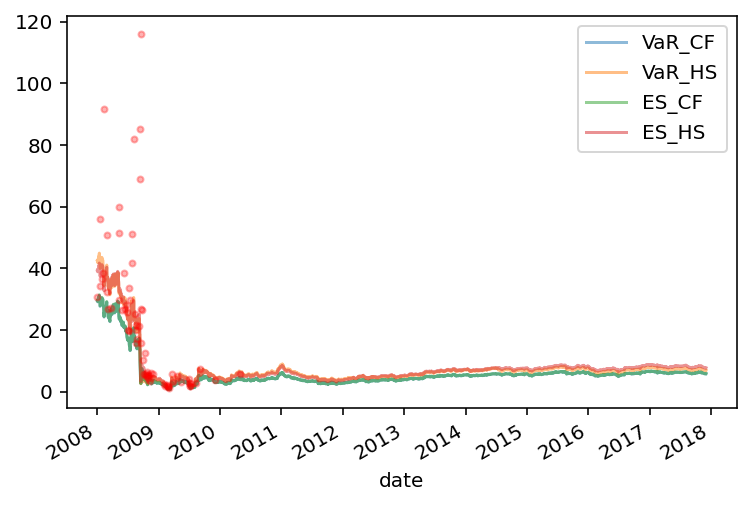

In [6]:
sub_aig_data2 = sub_aig_data2[sub_aig_data2.index>'20080101']
sub_aig_data2[['VaR_CF','VaR_HS','ES_CF','ES_HS']].plot(alpha=0.5)
plt.plot(-1*sub_aig_data2['P_and_L'][-1*sub_aig_data2['P_and_L']>sub_aig_data2['VaR_CF'] ]  , 'r.', alpha=0.3)

In the previous plot we show the calculated risk measures and the exceedances over the closed form value at risk, that is the occasions for which the losses where larger than the estimated value. Note that they seem to concentrate before year 2010. Let us make a zoom

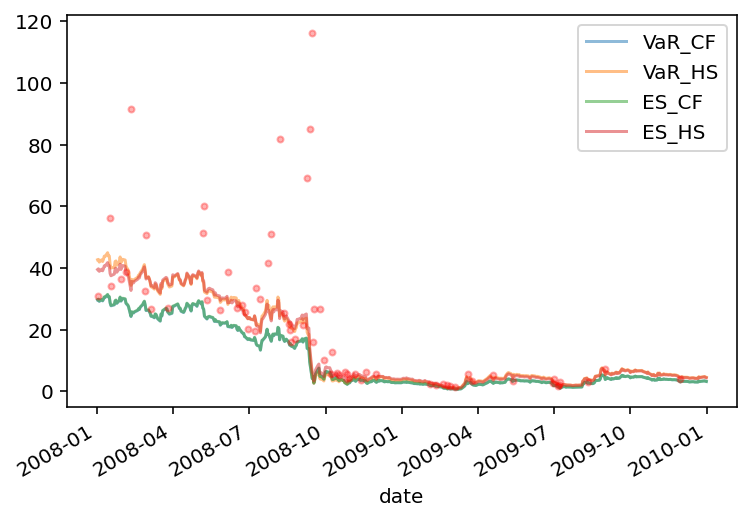

In [7]:
sub_aig_data2 = sub_aig_data2[ (sub_aig_data2.index>'20080101') & (sub_aig_data2.index<'20100101') ]
sub_aig_data2[['VaR_CF','VaR_HS','ES_CF','ES_HS']].plot(alpha=0.5)
plt.plot(-1*sub_aig_data2['P_and_L'][-1*sub_aig_data2['P_and_L']>sub_aig_data2['VaR_CF'] ]  , 'r.', alpha=0.3)

It seems quite clear that the risk measure estimation in this time frame is not good.

Let us repeat the exercise but this time with a rolling window of 5 years (approximately 1250 dates).

In [8]:
sub_aig_data3= risk_approx(sub_aig_data,'20080101',0.99,0.975,1250)

In [9]:
sub_aig_data3.head()

adj_close    P_and_L  log_price  log_returns  VaR_CF  VaR_HS  \
date                                                                        
2003-01-03  885.350097  -2.650749   6.785983    -0.002990     NaN     NaN   
2003-01-06  915.097389  29.747292   6.819030     0.033047     NaN     NaN   
2003-01-07  897.278467 -17.818922   6.799366    -0.019664     NaN     NaN   
2003-01-08  886.086416 -11.192050   6.786814    -0.012552     NaN     NaN   
2003-01-09  918.926249  32.839832   6.823206     0.036391     NaN     NaN   

            ES_CF  ES_HS  
date                      
2003-01-03    NaN    NaN  
2003-01-06    NaN    NaN  
2003-01-07    NaN    NaN  
2003-01-08    NaN    NaN  
2003-01-09    NaN    NaN

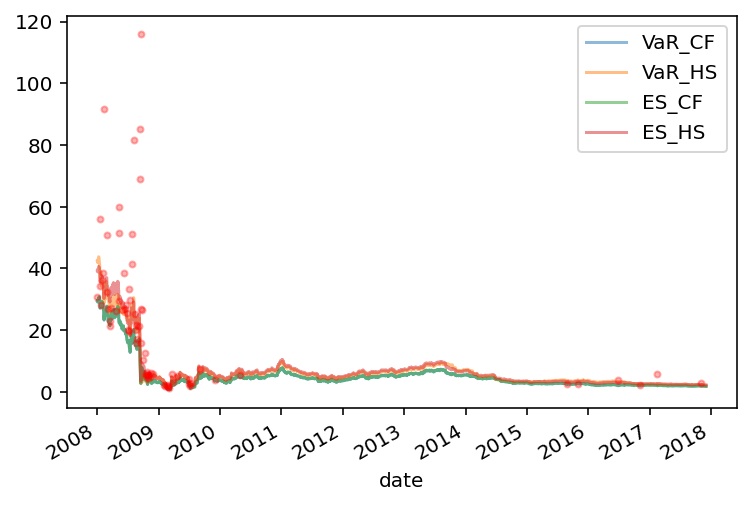

In [10]:
sub_aig_data3 = sub_aig_data3[sub_aig_data3.index>'20080101']
sub_aig_data3[['VaR_CF','VaR_HS','ES_CF','ES_HS']].plot(alpha=0.5)
plt.plot(-1*sub_aig_data3['P_and_L'][-1*sub_aig_data3['P_and_L']>sub_aig_data3['VaR_CF'] ]  , 'r.', alpha=0.3)

We can see that in this case, because the information during the crisis is lost, we have excesses also in the latest part of the database.

# Homework

Consider the database  in '~/Data/basket_20171201_10y.csv'. Perform a backtest of a historical simulation estimation for a portfolio with equal weights on this basket.
